# Process Raw Data


This Notebook provides the code to process the raw _.txt_ files collected by the Psytoolkit Experiments.

Experiments:
 - Navon
 - Fitts
 - N-Back
 - WCST
 - Corsi Block Span


#### Function
Extract raw data from _.txt_ files & store them in a programable datastructure (pandas dataframes)

#### Input
- file path: raw _.txt_ data
- file path: write _pandas dataframes_

#### Output
- stored, structured dataframes suitable for statistical computation



---------
```
Zach Wolpe
zachcolinwolpe@gmail.com
27 June 2021
```
---------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import pandas as pd
import pickle
import os
import re

In [87]:
class batch_processing:
    """
    Input:  path to data 
    Return: tools too write pandas dataframes of data to a specified location
    """
    def __init__(self, path_to_data):
        self.path            = path_to_data
        self.metadata        = None
        self.mapping         = pd.read_csv(self.path + '/data.csv', index_col=False).replace(np.nan, 'nan')
        self.data_times      = pd.read_csv(self.path + '/data_times.csv', index_col=False).replace(np.nan, 'nan')
        self.participants    = self.mapping['participant'].tolist()
        self.parti_code      = self.mapping['participant_code:1'].tolist()
        self.n               = self.mapping.shape[0]
        self.wcst_paths      = [self.path  + wp for wp in self.mapping['wcst_task:1'].tolist()]
        self.nback_paths     = [self.path  + wp for wp in self.mapping['n_back_task:1'].tolist()]
        self.corsi_paths     = [self.path  + wp for wp in self.mapping['corsi_block_span_task:1'].tolist()]
        self.fitts_paths     = [self.path  + wp for wp in self.mapping['fitts_law:1'].tolist()]
        self.navon_paths     = [self.path  + wp for wp in self.mapping['navon_task:1'].tolist()]
        self.wcst_data       = None
        self.nback_data      = None
        self.corsi_data      = None
        self.fitts_data      = None
        self.navon_data      = None
        self.individual_data = None
        self.MTurk           = None

    def describe_data(self):
        """Describe the available data associated with the class"""
        message = """

        ------------------------------------------------------------------
            self.path            : raw data loc
            self.metadata        : mturk metadata
            self.mapping         : reference table
            self.data_times      : reference times table
            self.participants    : list of participant identifiers
            self.parti_code      : list of participant codes
            self.n               : total number of samples
            self.wcst_paths      : paths to wcst  raw data
            self.nback_paths     : paths to nback raw data
            self.corsi_paths     : paths to corsi raw data
            self.fitts_paths     : paths to fitts raw data
            self.navon_paths     : paths to navon raw data
            self.wcst_data       : wcst  dataframe
            self.nback_data      : nback dataframe
            self.corsi_data      : corsi dataframe
            self.fitts_data      : fitts dataframe
            self.navon_data      : navon dataframe
            self.individual_data : psytoolkit metadata
            self.MTurk           : mturk completion data
        ------------------------------------------------------------------

        """
        print(message)
        

    
    def cache_metadata(self, metadata_path):
        """Store any metadata"""
        self.metadata = pd.read_csv(metadata_path, index_col=False).replace(np.NaN, 'nan')
        print('')
        print('     Metadata saved!     ')
        print('')

    def create_participant_data(self):
        individual_paths = [self.path + p for p in self.participants]
        df = pd.DataFrame({
            'participant':[],'participant_file':[], 'participant_code':[],
            'version':[],'server-time':[], 'user_agent':[], 'screen_width':[], 'screen_height':[], 'html_width':[], 'html_height':[], 
            'user_time':[], 'user_time_T':[], 
            'Welcome_Screen':[],'Welcome_Screen_stime':[],'Welcome_Screen_T':[],'Welcome_Screen_t':[],
            'participant_code':[],'participant_code_stime':[],'participant_code_t':[], 'participant_code_a':[],
            'feedback':[],'feedback_stime':[],'feedback_T':[],'feedback_t':[],
            'age':[],'age_stime':[],'age_T':[],'age_t':[],'age_a':[],
            'gender':[], 'gender_stime':[],'gender_T':[],'gender_t':[],'gender_a':[],
            'handedness':[],'handedness_stime':[],'handedness_T':[],'handedness_t':[],'handedness_a':[],
            'education':[], 'education_stime':[],'education_T':[],'education_t':[],'education_a':[],
            'income':[],'income_stime':[],'income_T':[],'income_t':[],'income_a':[],'income_s':[], 
            'computer_hours':[],'computer_hours_stime':[],'computer_hours_T':[],'computer_hours_t':[],'computer_hours_a':[],'computer_hours_s':[], 
            'wcst_task':[],'wcst_task_stime':[], 'wcst_task_T':[],'wcst_task_t':[], 
            'n_back_task':[],'n_back_task_stime':[],'n_back_task_T':[],'n_back_task_t':[],
            'corsi_block_span_task':[],'corsi_block_span_task_stime':[], 'corsi_block_span_task_T':[],'corsi_block_span_task_t':[],
            'fitts_law':[],'fitts_law_stime':[],'fitts_law_T':[],'fitts_law_t':[],
            'navon_task_law':[],'navon_task_stime':[], 'navon_task_T':[],'navon_task_t':[],
            'endcode':[],'end':[]
        })

        # trick to structure data 
        meta_cols = [
            'version', 'server-time', 'user_agent', 'screen_width', 'screen_height', 'html_width', 'html_height', 'user_time', 'Welcome_Screen',
            'participant_code', 'feedback','age', 'gender', 'handedness', 'education', 'income', 'computer_hours', 'wcst_task', 'n_back_task', 
            'corsi_block_span_task', 'fitts_law', 'navon_task', 'endcode', 'end']

        for p in range(self.n):        
            # _____ FOR EACH PARTICIPANT -----x
            pc = self.parti_code[p]
            pt = self.participants[p]

            f = open(individual_paths[p], 'r')
            # core dictionary
            dt  = {
                    'participant':              pc,
                    'participant_file':         pt,
                }
            c = 0
            prefix = ''
            for l in f.readlines():
                # ----- For each line ----x
                st  = l.split(' ')

                # identify prefix (from 'meta_cols')
                x = [meta_cols[i] for i in np.where([m in l for m in meta_cols])[0]]
                if len(x) > 0: 
                    prefix = x[0]
                    dtt  = {prefix: st[1].split('\n')[0]}
                

                else:
                    dtt  = {prefix + '_' + st[0].split(':')[0]: st[1].split('\n')[0]}
                dt.update(dtt)
                c = c+1
            df = df.append(dt, ignore_index=True)[df.keys()]
            f.close()
        message = """

        ------------------------------------------------------------------
                                Individual data created
        ------------------------------------------------------------------

        """
        print(message)
        self.individual_data = df




    
    def mturk_completion_rates(self):
        """Compute the completion rates for each task as well as return the WorkerIDs that completed all Tasks"""
        # ---- join metadata ----x
        # metadata:        MTurk      generated metadata
        # inidvidual_data: Psytoolkit generated metadata
        df = pd.merge(self.metadata, self.individual_data, left_on='Answer.surveycode', right_on='participant_code_a', how='outer')


        # ---- number of tasks started ----x
        sub = df[['WorkerId', 'wcst_task_stime', 'n_back_task_stime', 'corsi_block_span_task_stime', 'fitts_law_stime', 'navon_task_stime']]
        sub = sub.set_index(['WorkerId']).notnull()


        # ----- WorkerIDs who completed all Tasks -----x
        complete = sub.loc[sub.sum(axis=1)==5,].index
        complete = ['nan' if d != d else d for d in complete]

        # ----- WorkerIDs who DID NOT completed all Tasks -----x
        incomplete = sub.loc[sub.sum(axis=1)!=5,].index
        incomplete = ['nan' if d != d else d for d in incomplete]

        MTurk = {
            'merged_dataframe':                         df,
            'Worker_IDs_that_completed_tasks':          complete,
            'Worker_IDs_that_DID_NOT_completed_tasks':  incomplete
            }
        message = """

        ------------------------------------------------------------------
                          MTurk workers data analyzed
        ------------------------------------------------------------------

        """
        print(message)
        self.MTurk = MTurk

        # ----- Visiualize Performance ----x
        plt_data = sub.sum().to_frame().transpose()
        plt_data.columns = [t.replace('_stime', '') for t in  plt_data.columns]
        plt_data.columns = [x + ': ' + str(y) for x,y in zip(plt_data.columns, plt_data.values[0])]
        plt_data.plot.bar().set_ylim(200,300)
        plt.title('Number of Tasks Started')
        plt.xticks([])
        plt.show()





    def create_wcst_data(self):
        df = pd.DataFrame()
        for p in range(self.n):
            # ----- check path validity -----x
            if os.path.exists(self.wcst_paths[p]):

                # _____ FOR EACH PARTICIPANT -----x
                pc = self.parti_code[p]
                pt = self.participants[p]

                # _____ FOR EACH PARTICIPANT -----x
                f = open(self.wcst_paths[p], 'r')
                for l in f.readlines():
                    st  = l.split(' ')
                    crd = re.split(r'(\d+)', st[5]) 
                    dt  = {
                        'participant':            pc,
                        'participant_code':       pt,
                        'card_no':                st[0],
                        'correct_card':           st[1],
                        'correct_persevering':    st[2],
                        'seq_no':                 st[3],
                        'rule':                   st[4],
                        'card_shape':             crd[0],
                        'card_number':            crd[1],
                        'card_colour':            crd[2],
                        'reaction_time_ms':       st[6],
                        'status':                 st[7],
                        'card_selected':          st[8],
                        'error':                  st[9],
                        'perseverance_error':     st[10],
                        'not_perseverance_error': st[11].split('\n')[0],
                    }
                    df = df.append(dt, ignore_index=True)[dt.keys()]
                f.close()
        message = """

        ------------------------------------------------------------------
                                WCST data created
        ------------------------------------------------------------------

        """
        print(message)
        self.wcst_data = df


    def create_navon_data(self):
        df = pd.DataFrame()
        for p in range(self.n):
            # ----- check path validity -----x
            if os.path.exists(self.navon_paths[p]):

                # _____ FOR EACH PARTICIPANT -----x
                pc = self.parti_code[p]
                pt = self.participants[p]

                # _____ FOR EACH PARTICIPANT -----x
                f = open(self.navon_paths[p], 'r')
                for l in f.readlines():
                    st  = l.split(' ')
                    dt  = {
                        'participant':            pc,
                        'participant_code':       pt,
                        'large_letter':           st[0][0],
                        'small_letter':           st[0][0],
                        'level_of_target':        st[1],
                        'level_of_target_n':      st[2],
                        'status':                 st[3],
                        'reaction_time_ms':       st[4].split('\n')[0],
                    }
                    df = df.append(dt, ignore_index=True)[dt.keys()]
                f.close()
        message = """

        ------------------------------------------------------------------
                                Navon data created
        ------------------------------------------------------------------

        """
        print(message)
        self.navon_data = df


    def create_nback_data(self):
        df = pd.DataFrame()
        for p in range(self.n):
            # ----- check path validity -----x
            if os.path.exists(self.nback_paths[p]):
                # _____ FOR EACH PARTICIPANT -----x
                pc = self.parti_code[p]
                pt = self.participants[p]

                # _____ FOR EACH PARTICIPANT -----x
                f = open(self.nback_paths[p], 'r')
                for l in f.readlines():
                    st  = l.split(' ')
                    dt  = {
                        'participant':              pc,
                        'participant_code':         pt,
                        'block_number':             st[0],
                        'trial_counter':            st[1],
                        'score':                    st[2],
                        'status':                   st[3],
                        'miss':                     st[4],
                        'false_alarm':              st[5],
                        'unknown':                  st[6],
                        'reaction_time_ms':         st[7],
                        'match':                    st[8],
                        'stimuli':                  st[9],
                        'stimuli_n_1':              st[10],
                        'stimuli_n_2':              st[11].split('\n')[0],
                    }
                    df = df.append(dt, ignore_index=True)[dt.keys()]
                f.close()
        message = """

        ------------------------------------------------------------------
                                N back data created
        ------------------------------------------------------------------

        """
        print(message)
        self.nback_data = df


    def create_corsi_data(self):
        df = pd.DataFrame()
        for p in range(self.n):
            # ----- check path validity -----x
            if os.path.exists(self.corsi_paths[p]):
            
                # _____ FOR EACH PARTICIPANT -----x
                pc = self.parti_code[p]
                pt = self.participants[p]

                # _____ FOR EACH PARTICIPANT -----x
                f = open(self.corsi_paths[p], 'r')
                for l in f.readlines():
                    st  = l.split(' ')
                    dt  = {
                        'participant':              pc,
                        'participant_code':         pt,
                        'highest_span':             st[0],
                        'n_items':                  st[1],
                        'status':                   st[2].split('\n')[0],
                    }
                    df = df.append(dt, ignore_index=True)[dt.keys()]
                f.close()
        message = """

        ------------------------------------------------------------------
                                Corsi data created
        ------------------------------------------------------------------

        """
        print(message)
        self.corsi_data = df



    def create_fitts_data(self):
        df = pd.DataFrame()
        for p in range(self.n):

            # ----- check path validity -----x
            if os.path.exists(self.fitts_paths[p]):

                # _____ FOR EACH PARTICIPANT -----x
                pc = self.parti_code[p]
                pt = self.participants[p]

                # _____ FOR EACH PARTICIPANT -----x
                f = open(self.fitts_paths[p], 'r')
                for l in f.readlines():
                    st  = l.split(' ')
                    dt  = {
                        'participant':              pc,
                        'participant_code':         pt,
                        'x_loc':                    st[0],
                        'y_loc':                    st[1],
                        'size':                     st[2],
                        'distance':                 st[3],
                        'fitts_prediction':         st[4],
                        'reaction_time_ms':         st[5],
                        'status':                   st[6].split('\n')[0],
                    }
                    df = df.append(dt, ignore_index=True)[dt.keys()]
                f.close()
        message = """

        ------------------------------------------------------------------
                                Fitts data created
        ------------------------------------------------------------------

        """
        print(message)
        self.fitts_data = df


    # -------------- precess meta


    def convert_data_to_int(self):
        """Change the schema of the dataframes to include integers"""
        # converter function
        def str_to_int(df, columns):
            for c in columns: df[c] = df[c].astype(int)
            return(df)

        # convert schemas
        self.fitts_data = str_to_int(self.fitts_data, 
        ['x_loc', 'y_loc', 'size', 'distance', 'fitts_prediction', 'reaction_time_ms', 'status'])

        self.corsi_data = str_to_int(self.corsi_data, ['highest_span', 'n_items', 'status'])

        self.nback_data = str_to_int(self.nback_data, 
        ['block_number', 'score', 'status','miss', 'false_alarm', 'reaction_time_ms', 'match', 
        'stimuli','stimuli_n_1', 'stimuli_n_2'])

        self.wcst_data = str_to_int(self.wcst_data, 
        ['card_no', 'correct_card', 'correct_persevering', 'seq_no', 'card_number', 'reaction_time_ms', 'status', 
        'card_selected', 'error', 'perseverance_error', 'not_perseverance_error'])

        self.navon_data = str_to_int(self.navon_data, ['level_of_target_n', 'status', 'reaction_time_ms'])
        message="""
        ------------------------------------------------------------------
        Schemas Converted!
        ------------------------------------------------------------------
        """
        print(message)


    def write_to_pickle(self, path):
        """Write the data to pickle files"""
        try: os.mkdir(path)
        except: None

        self.fitts_data.to_pickle(path      + 'fitts_data.pkl')
        self.wcst_data.to_pickle(path       + 'wcst_data.pkl')
        self.nback_data.to_pickle(path      + 'nback_data.pkl')
        self.corsi_data.to_pickle(path      + 'corsi_data.pkl')
        self.navon_data.to_pickle(path      + 'navon_data.pkl')
        self.metadata.to_pickle(path        + 'metadata.pkl')
        self.mapping.to_pickle(path         + 'mapping.pkl')
        self.data_times.to_pickle(path      + 'data_times.pkl')
        self.individual_data.to_pickle(path + 'individual_data.pkl')
        message="""
        ------------------------------------------------------------------
        Dataframes successfully written to path {}!
        ------------------------------------------------------------------
        """.format(path)
        print(message)


    def read_from_pickle(self, path):
        """Read the data to pickle files"""
        self.fitts_data = pd.read_pickle(path + 'fitts_data.pkl')
        self.wcst_data  = pd.read_pickle(path + 'wcst_data.pkl')
        self.nback_data = pd.read_pickle(path + 'nback_data.pkl')
        self.corsi_data = pd.read_pickle(path + 'corsi_data.pkl')
        self.navon_data = pd.read_pickle(path + 'navon_data.pkl')
        message="""
        ------------------------------------------------------------------
        Dataframes:

            - fitts_data
            - wcst_data
            - nback_data
            - corsi_data
            - navon_data

        Successfully read from path: \'{}\'!
        ------------------------------------------------------------------
        """.format(path)
        print(message)


    def write_class_to_pickle(self, path):
        """serialize object to pickle object"""

        #save it
        filename = path + 'batch_processing_object.pkl'
        with open(filename, 'wb') as file:
            pickle.dump(self, file) 

        # #load it
        # with open(filename, 'rb') as file2:
        #     bp = pickle.load(file2)
        message="""
        ------------------------------------------------------------------
        Object successfully written to path: \'{}\'!

        To retrieve run:
            with open(\'{}\', 'rb') as file2:
                bp = pickle.load(file2)
        ------------------------------------------------------------------
        """.format(filename, filename)
        print(message)

# Instantiate
Instantiate the class & provide the file locations. Save the processed object as a _.pkl_ file - compressing the datastructure.


     Metadata saved!     



        ------------------------------------------------------------------
                                Individual data created
        ------------------------------------------------------------------

        


        ------------------------------------------------------------------
                          MTurk workers data analyzed
        ------------------------------------------------------------------

        


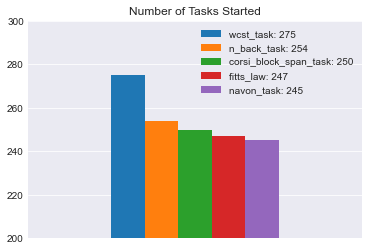



        ------------------------------------------------------------------
                                WCST data created
        ------------------------------------------------------------------

        


        ------------------------------------------------------------------
                                Navon data created
        ------------------------------------------------------------------

        


        ------------------------------------------------------------------
                                N back data created
        ------------------------------------------------------------------

        


        ------------------------------------------------------------------
                                Corsi data created
        ------------------------------------------------------------------

        


        ------------------------------------------------------------------
                                Fitts data created
        ------------

In [88]:
# ---- Deprecated ----x
path  = '../../../Data/mturk/data - MTurk- 26 May 2021/'
path2 = '../data objects/'
meta  ='../../../Data/mturk/Batch_4453805_batch_results - 6 May 2021.csv'

mturk_path = path
meta_path  = meta
write_path = path2

# ---- Updated ----x
base_path  = '../../../Data/mturk - final data/'
mturk_path = base_path + 'mturk data - 04 June 2021/'
meta_path  = base_path + 'Batch_4453805_batch_results - 04 June 2021.csv'
write_path = '../data objects/'

# ---- call scripts ---x
bp   = batch_processing(mturk_path)
bp.cache_metadata(meta_path)
bp.create_participant_data()
bp.mturk_completion_rates()
bp.create_wcst_data()
bp.create_navon_data()
bp.create_nback_data()
bp.create_corsi_data()
bp.create_fitts_data()
bp.convert_data_to_int()
bp.write_class_to_pickle(write_path)